**Shashi Sharma, ss139529@gmail.com**

# Amazon Fine Food Reviews Analysis using Logistic Regression


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY TIME DESC LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
ActualScore = filtered_data['Score']
positiveNegative = ActualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
1,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ..."
2,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...
3,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl..."
4,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head() #BY DEFAULT IT DISPLAY 5 ROWS

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(71551, 10)

In [10]:
#Sorting data according to Time in descending order
final=final.sort_values('Time', axis=0, ascending=True)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.551

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
Score=final['Score']
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(71551, 10)


1    59256
0    12295
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.
I love this litter and it is well worth the money.  First of all its light and I no longer have to lug heavy bags or boxes home from the store.  Even though it clumps well around my cat's waste, it can be shaken off and the waste disposed of in my toilet.  I do this every day.  There is absolutely no odor anymore and no more little pieces of cat litter and dust being tracked out of the box.  I wish I had known about this before but I'm grateful I know of it now.  My cat is fine with it and acts as though nothing has changed.  I give this 5 stars because there aren't more stars available.
I bought this because it is a green product. However, it was more trouble then it worth. It's hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.
I got a pack from my mother-in-law one day to eat as a snack at

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.
I love this litter and it is well worth the money.  First of all its light and I no longer have to lug heavy bags or boxes home from the store.  Even though it clumps well around my cat's waste, it can be shaken off and the waste disposed of in my toilet.  I do this every day.  There is absolutely no odor anymore and no more little pieces of cat litter and dust being tracked out of the box.  I wish I had known about this before but I'm grateful I know of it now.  My cat is fine with it and acts as though nothing has changed.  I give this 5 stars because there aren't more stars available.
I bought this because it is a green product. However, it was more trouble then it worth. It's hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.
I got a pack from my mother-in-law one day to eat as a snack at

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought this because it is a green product. However, it was more trouble then it worth. It is hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega  fatty nutrients.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought this because it is a green product However it was more trouble then it worth It is hard to scoop needs frequent changing it tracks worse around the house and it does nothing to control the cat smell issue 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(word.lower() for word in sentance.split() if word.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 71551/71551 [00:58<00:00, 1219.95it/s]


In [24]:
#comparing the raw data and the preprocessed data:

print(sent_0) 
print("####")
print(preprocessed_reviews[0])

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega  fatty nutrients.
####
good glad ordered taste lot like tuna fish u get omega fatty nutrients


In [25]:
preprocessed_reviews[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue'

In [26]:
# printing some random summary
summ_0 = final['Summary'].values[0]
print(summ_0)
print("="*50)

summ_1000 = final['Summary'].values[1000]
print(summ_1000)

Sardines
The best litter I've ever used!!!


In [27]:
## preprocessing the review summary to be use for feature engineering later. 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in (final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should pr

In [28]:
preprocessed_summary[1500]

'bad product'

# [4] Featurization

#### Splitting the preprocessed_reviews data:

In [29]:
Y = Score
X= preprocessed_reviews

In [30]:
np.shape(X)

(71551,)

In [31]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X_train= X[0:50086]
X_test= X[50086:]
y_train= Y[0:50086]
y_test= Y[50086:]

In [32]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))


(50086,) (50086,)
(21465,) (21465,)


## [4.1] BAG OF WORDS

In [82]:
#BoW
count_vect = CountVectorizer(dtype='float')
count_vect.fit(X_train) # fit has to happen only on train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the number of unique words in X_train",X_train_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaahhhhh', 'aaaaallll', 'aaaahhhhhhhhhhh', 'aaaannnnddd', 'aaah', 'aabout']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train 42876
After vectorizations
(50086, 42876) (50086,)
(21465, 42876) (21465,)


## [4.2] Bi-Grams and n-Grams.

In [34]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) 
count_vect.fit(X_train)
print('='*50)

X_train_big = count_vect.transform(X_train)
X_test_big = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_big))
print('='*50)

print("After vectorizations")
print(X_train_big.shape, y_train.shape)
print(X_test_big.shape, y_test.shape)

print("the number of unique words including both unigrams and bigrams in X_train ", X_train_big.shape[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 5000) (50086,)
(21465, 5000) (21465,)
the number of unique words including both unigrams and bigrams in X_train  5000


## [4.3] TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_big))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 30052) (50086,)
(21465, 30052) (21465,)
The number of unique words in tf_idf_vect of X_train  30052


## [4.4] Word2Vec

In [36]:
# Train your own Word2Vec model using your own text corpus
i=0
X_train_los=[]
for sentance in X_train:
    X_train_los.append(sentance.split())

k=0
X_test_los=[]
for sentance in X_test:
    X_test_los.append(sentance.split())

In [37]:
# min_count = 5 considers only words that occured atleast 5 times
#Conveting X_train to w2v
X_trainw2v=Word2Vec(X_train_los,min_count=5,size=50, workers=4)
print(X_trainw2v.wv.most_similar('great'))
print('='*50)


X_testw2v=Word2Vec(X_test_los,min_count=5,size=50, workers=4)
print(X_testw2v.wv.most_similar('great'))



[('awesome', 0.8582444190979004), ('good', 0.83689284324646), ('fantastic', 0.8184249401092529), ('excellent', 0.7945510149002075), ('terrific', 0.7815141677856445), ('wonderful', 0.7721036076545715), ('perfect', 0.7643352746963501), ('fabulous', 0.7248638272285461), ('amazing', 0.7184268832206726), ('incredible', 0.6999317407608032)]
[('good', 0.8182591199874878), ('excellent', 0.8066108822822571), ('wonderful', 0.7986730337142944), ('fantastic', 0.7562503218650818), ('awesome', 0.7537949681282043), ('perfect', 0.7229082584381104), ('amazing', 0.684680163860321), ('delicious', 0.6796684861183167), ('love', 0.655672013759613), ('decent', 0.6388846635818481)]


In [38]:
X_train_w2v_words = list(X_trainw2v.wv.vocab)
print("number of words that occured minimum 5 times in X_train_w2v_words",len(X_train_w2v_words))
print('='*50)

X_test_w2v_words = list(X_testw2v.wv.vocab)
print("number of words that occured minimum 5 times in X_train_w2v_words",len(X_test_w2v_words))
print('='*50)

number of words that occured minimum 5 times in X_train_w2v_words 13760
number of words that occured minimum 5 times in X_train_w2v_words 8842


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [39]:
# average Word2Vec for X_TRAIN
X_train_w2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_train_los: # for each review/sentence in X_TRAIN
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in X_train_w2v_words:
            vec = X_trainw2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_w2v.append(sent_vec)
print(len(X_train_w2v))
print(len(X_train_w2v[0]))
print('='*50)


# average Word2Vec for X_TEST
X_test_w2v=[];
for sent in X_test_los: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in X_test_w2v_words:
            vec = X_testw2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_w2v.append(sent_vec)
print(len(X_test_w2v))
print(len(X_test_w2v[0]))

50086
50
21465
50


#### [4.4.1.2] TFIDF weighted W2v

In [40]:
# Sentence = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tfidf_los = model.fit(X_train)
X_train_tfidf_feat = model.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
X_train_dictionary = dict(zip(X_train_tfidf_feat, list(X_train_tfidf_los.idf_)))


model2 = TfidfVectorizer()
X_test_tfidf_los = model2.fit(X_test)
X_test_tfidf_feat = model2.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
X_test_dictionary = dict(zip(X_test_tfidf_feat, list(X_test_tfidf_los.idf_)))

In [42]:
# TF-IDF weighted Word2Vec for X_TRAIN, X_CV and X_test:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
a=0;
for sent in tqdm(X_train_los): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in X_train_w2v_words and word in X_train_tfidf_feat:
            vec = X_trainw2v.wv[word]
            tf_idf = X_train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    a += 1


X_test_tfidfw2v = [];
b=0;
for sent in tqdm(X_test_los): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in X_test_w2v_words and word in X_test_tfidf_feat:
            vec = X_testw2v.wv[word]
            tf_idf = X_test_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    b += 1

100%|███████████████████████████████████████████████████████████████████████████| 21465/21465 [02:38<00:00, 135.59it/s]


In [41]:
#pd.to_pickle(X_train_tfidfw2v,'Xtrain_tfidfw2v')
#pd.to_pickle(X_test_tfidfw2v,'Xtest_tfidfw2v')
X_train_tfidfw2v=pd.read_pickle('Xtrain_tfidfw2v')
X_test_tfidfw2v=pd.read_pickle('Xtest_tfidfw2v')

# [5] Assignment 12: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying Logistic Regression:

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [89]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard = StandardScaler(with_mean=False).fit(X_train_bow) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_bow_S = Standard.transform(X_train_bow)
X_test_bow_S = Standard.transform(X_test_bow)

In [90]:
X_train_bow_S

<50086x42876 sparse matrix of type '<class 'numpy.float64'>'
	with 1672115 stored elements in Compressed Sparse Row format>

In [91]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf= clf.fit(X_train_bow_S, y_train)

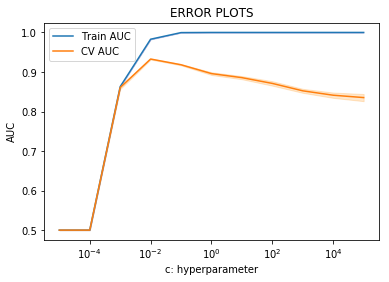

In [92]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(c, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [93]:
l=0
for i in c:
    print (i,train_auc[l],cv_auc[l],train_auc[l]-cv_auc[l] )
    l+=1

1e-05 0.5 0.5 0.0
0.0001 0.5 0.5 0.0
0.001 0.8628178414570922 0.860512252200116 0.002305589256976215
0.01 0.982881532981201 0.9327432754735856 0.05013825750761536
0.1 0.9996196378910492 0.918276774504854 0.08134286338619523
1 0.9999959961943711 0.8958968398731693 0.10409915632120181
10 0.9999982963617048 0.8856326288146021 0.11436566754710265
100 0.9999982963617048 0.8710460166137273 0.12895227974797752
1000 0.999998296361705 0.8522996258446567 0.14769867051704832
10000 0.999998296361705 0.8412251481920007 0.15877314816970434
100000 0.999998296361705 0.8352512579553008 0.16474703840640426


In [94]:
print(clf.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [49]:
# Taking best c as per the graph and best_estimator_ function.
# c value here is inverse of lamda
#
#best_c=0.01 # lamda = 100

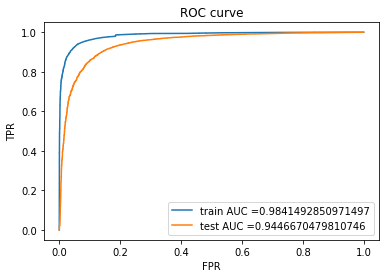

In [95]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
LR = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
LR.fit(X_train_bow_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_bow_S)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_bow_S)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


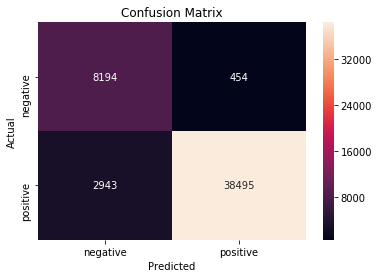

Test confusion matrix


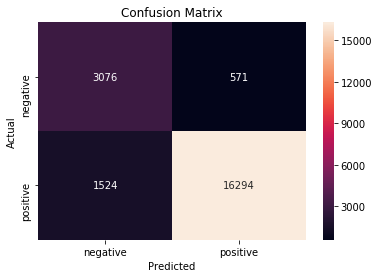

In [96]:
# Confusion matrix
print("Train confusion matrix")
matrix_train= confusion_matrix(y_train, LR.predict(X_train_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train = pd.DataFrame(matrix_train,columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test= confusion_matrix(y_test, LR.predict(X_test_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test = pd.DataFrame(matrix_test,columns,index)
sns.heatmap(df_matrix_test, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [97]:
# Please write all the code with proper documentation
# Sparsity increase with the increase of Lamda value. Or with the decrease of c value.
# w1 is the weight vector using L1 regularization

W_l1=LR.coef_
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector ',np.count_nonzero(W_l1))

No of non zero element in weight vector  4429


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [98]:
# Please write all the code with proper documentation

In [99]:
logistic_ = LogisticRegression(penalty='l2', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf1 = GridSearchCV(logistic_, C, cv=3, scoring='roc_auc', return_train_score= True )
clf1= clf1.fit(X_train_bow_S, y_train)

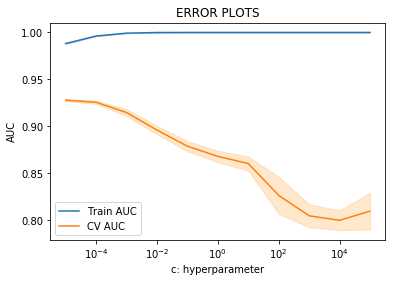

In [100]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc1= clf1.cv_results_['mean_train_score']
train_auc_std1= clf1.cv_results_['std_train_score']
cv_auc1 = clf1.cv_results_['mean_test_score'] 
cv_auc_std1= clf1.cv_results_['std_test_score']

plt.semilogx(c, train_auc1, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc1 - train_auc_std1,train_auc1 + train_auc_std1,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc1, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc1 - cv_auc_std1,cv_auc1 + cv_auc_std1,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [101]:
print(clf1.best_estimator_)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [102]:
#best_c=1e-05

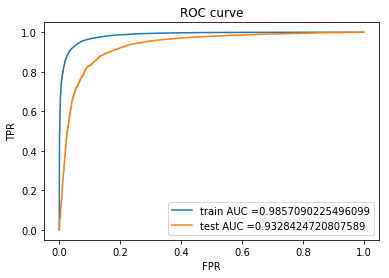

In [103]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
LR1 = LogisticRegression(penalty='l2', C=1e-05, class_weight = 'balanced')
LR1.fit(X_train_bow_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, LR1.predict_proba(X_train_bow_S)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, LR1.predict_proba(X_test_bow_S)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


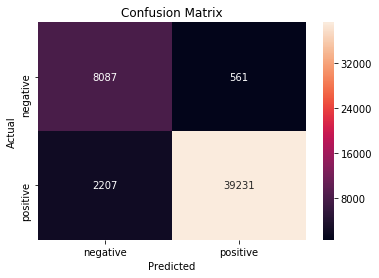

Test confusion matrix


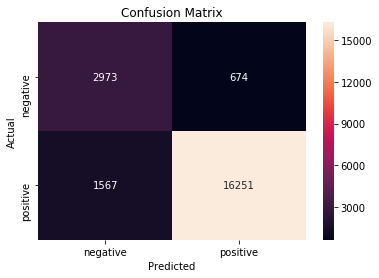

In [104]:
# Confusion matrix
print("Train confusion matrix")
matrix_train1= confusion_matrix(y_train, LR1.predict(X_train_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1 = pd.DataFrame(matrix_train1,columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test1= confusion_matrix(y_test, LR1.predict(X_test_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test1 = pd.DataFrame(matrix_test1,columns,index)
sns.heatmap(df_matrix_test1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [105]:
# Please write all the code with proper documentation

In [106]:
W_l2=LR1.coef_ # Weight using L2 regularization after fitting the X_train_bow_S with the model LR1
X_n=X_train_bow_S

In [107]:
# Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
Noise= np.random.normal(loc=0.0, scale=0.000001, size=X_n.data.shape)
X_n.data= X_n.data + Noise
X_n.shape # Shape of the new data set X_n (X_train_bow_S with noise)

(50086, 42876)

In [108]:
#Training the model with new data
LR1_n = LogisticRegression(penalty='l2', C=1e-05, class_weight = 'balanced')
LR1_n.fit(X_n, y_train)
W_l2_n=LR1_n.coef_ #new Weight using L2 regularization after fitting the new data with noise with the new model LR1_n

In [109]:
# Adding a small eps value(to eliminate the divisible by zero error) to the new and old weighsts:
W_l2+= 0.000001
W_l2_n+= 0.000001

In [110]:
len(W_l2[0])

42876

In [111]:
# Now find the % change between W_l2 and W_L2_n:  (| (W_L2-W_L2_n) / (W_L2) |)*100)
per_differ=[]
for i in range(len(W_l2[0])):
    diff= W_l2[0][i]-W_l2_n[0][i]
    diff/=W_l2[0][i]
    per_differ.append(diff)
per_differ= np.absolute(per_differ)    
per_differ_S=sorted(np.absolute(per_differ))[::-1]
per_differ_S[:5] # To print top 5 per_difference between weights.

[0.00022174089646627638,
 0.00018565701885265055,
 0.00013361473004438914,
 0.00013152316629961422,
 7.320075060373824e-05]

In [112]:
# Finding the feature name corresponding to the weight difference(per_diff)
feature_name= count_vect.get_feature_names()
#print(feature_name[per_differ.index(np.percentile(per_differ_S,i))])

In [113]:
#calculating percentiles from 0 to 100:
for i in range(0,11):
    print(str(i*10)+"th Percentile"+": "+str(np.percentile(per_differ,i*10)))
#+str(feature_name[per_differ.index(np.percentile(per_differ_S,i*10))]))

0th Percentile: 2.3846426348443986e-13
10th Percentile: 2.9764326557663673e-09
20th Percentile: 5.992256857941619e-09
30th Percentile: 9.232628205351552e-09
40th Percentile: 1.291788234405169e-08
50th Percentile: 1.727144259527496e-08
60th Percentile: 2.2540143237135815e-08
70th Percentile: 2.9504057338206305e-08
80th Percentile: 4.028447465013353e-08
90th Percentile: 6.551658803864125e-08
100th Percentile: 0.00022174089646627638


In [114]:
#calculating percentiles from 90th to 100th:
for i in range(90,101):
    print(str(i)+"th Percentile"+": "+str(np.percentile(per_differ,i)))

90th Percentile: 6.551658803864125e-08
91th Percentile: 6.985072840737711e-08
92th Percentile: 7.593246914121776e-08
93th Percentile: 8.40654448191519e-08
94th Percentile: 9.380611615021394e-08
95th Percentile: 1.0911249920166171e-07
96th Percentile: 1.3252355174690244e-07
97th Percentile: 1.6810815061814005e-07
98th Percentile: 2.472734948456805e-07
99th Percentile: 5.202510182726748e-07
100th Percentile: 0.00022174089646627638


In [115]:
#calculating percentiles from 99.0th to 100th:
for i in range(0,11):
    print(str(99+(0.1)*i)+"th Percentile"+": "+str(np.percentile(per_differ,99+(0.1)*i)))

99.0th Percentile: 5.202510182726748e-07
99.1th Percentile: 5.766598001111958e-07
99.2th Percentile: 6.461654578517148e-07
99.3th Percentile: 7.076700003134064e-07
99.4th Percentile: 8.399667831140028e-07
99.5th Percentile: 9.495024462950842e-07
99.6th Percentile: 1.204424615122541e-06
99.7th Percentile: 1.6712198663926775e-06
99.8th Percentile: 2.435791809554935e-06
99.9th Percentile: 4.7930215930668914e-06
100.0th Percentile: 0.00022174089646627638


In [116]:
#calculating percentiles from 99.9th to 100th:
for i in range(1,11):
    print(str(99.9+(0.01)*i)+"th Percentile"+": "+str(np.percentile(per_differ,99.9+(0.01)*i)))

99.91000000000001th Percentile: 5.300785887901937e-06
99.92th Percentile: 5.863859656321192e-06
99.93th Percentile: 6.304002889424764e-06
99.94000000000001th Percentile: 7.359017337193242e-06
99.95th Percentile: 8.669911204072975e-06
99.96000000000001th Percentile: 1.0254545644474641e-05
99.97th Percentile: 1.3285101304242058e-05
99.98th Percentile: 2.2381572471330277e-05
99.99000000000001th Percentile: 7.11232057984773e-05
100.0th Percentile: 0.00022174089646627638


In [117]:
#calculating percentiles from 99.9th to 100th:
for i in range(1,11):
    print(str(99.99+(0.001)*i)+"th Percentile"+": "+str(np.percentile(per_differ,99.99+(0.001)*i)))

99.991th Percentile: 8.143879182081466e-05
99.99199999999999th Percentile: 0.00010644452755037058
99.993th Percentile: 0.00013145026327992648
99.994th Percentile: 0.00013241730980051645
99.99499999999999th Percentile: 0.00013331406775607166
99.996th Percentile: 0.00014844678235454673
99.997th Percentile: 0.00017075991368142206
99.99799999999999th Percentile: 0.0001907989714123927
99.999th Percentile: 0.00020626993393920326
100.0th Percentile: 0.00022174089646627638


In [118]:
per_differ=per_differ.tolist()
print(feature_name[per_differ.index(np.percentile(per_differ_S,99.99+(0.001)*10))])

aftertase


##### Observation from pertubation test:
- We can observe that there is no any sudden rise in the values of percentage_change_vector greater than the thresold value 2.5. Therefore, we can say that our features are not collinear and multicollinear.
- Although % weight difference is not more than a threshold x(in our example it's 2.5), printing the feature name for the 100th percentile for reference.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class using  L1 regularization on <font color='red'> SET 1</font>

In [119]:
# Please write all the code with proper documentation
positive_feat = np.argsort(W_l1)[:,::-1] #Returns sorted indexs the features having the highest weights at the top
print("Top 10 positive features from BOW:")
for i in list(positive_feat[0][0:10]):
    print(feature_name[i])

Top 10 positive features from BOW:
great
best
love
good
delicious
perfect
excellent
loves
nice
wonderful


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [120]:
# Please write all the code with proper documentation
negative_feat = np.argsort(W_l1) #Returns sorted indexs the features having the least weights at the top
print("Top 10 Negative features from BOW:")
for i in list(negative_feat[0][0:10]):
    print(feature_name[i])

Top 10 Negative features from BOW:
not
disappointed
worst
terrible
disappointing
unfortunately
money
awful
stale
waste


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [121]:
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard1 = StandardScaler(with_mean=False).fit(X_train_tfidf) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_tfidf_S = Standard1.transform(X_train_tfidf)
X_test_tfidf_S = Standard1.transform(X_test_tfidf)

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [122]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf2 = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf2= clf2.fit(X_train_tfidf_S, y_train)

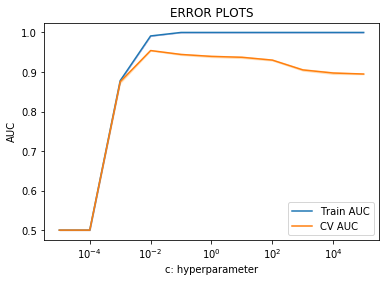

In [123]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc2= clf2.cv_results_['mean_train_score']
train_auc_std2= clf2.cv_results_['std_train_score']
cv_auc2 = clf2.cv_results_['mean_test_score'] 
cv_auc_std2= clf2.cv_results_['std_test_score']

plt.semilogx(c, train_auc2, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc2 - train_auc_std2,train_auc2 + train_auc_std2,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc2, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc2 - cv_auc_std2,cv_auc2 + cv_auc_std2,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [124]:
l=0
for i in c:
    print (i,train_auc2[l],cv_auc2[l],train_auc2[l]-cv_auc2[l] )
    l+=1

1e-05 0.5 0.5 0.0
0.0001 0.5 0.5 0.0
0.001 0.8779671384059625 0.8750482454837826 0.0029188929221799498
0.01 0.9911616812976641 0.9542210071586867 0.03694067413897739
0.1 0.9999901051834769 0.9443435269276961 0.05564657825578079
1 0.9999982628757268 0.9394137300602383 0.06058453281548848
10 0.9999982963617048 0.9371510142930087 0.06284728206869605
100 0.999998296361705 0.930071133702406 0.06992716265929899
1000 0.9999982963617048 0.905244666700361 0.09475362966134382
10000 0.999998296361705 0.8973458924262796 0.10265240393542541
100000 0.999998296361705 0.8948660583165072 0.10513223804519778


In [125]:
print(clf.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [162]:
#best_c=0.01

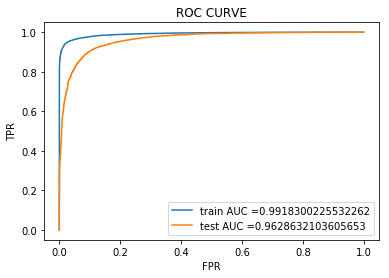

In [126]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR2 = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
LR2.fit(X_train_tfidf_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, LR2.predict_proba(X_train_tfidf_S)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, LR2.predict_proba(X_test_tfidf_S)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


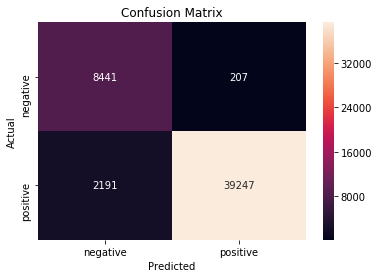

Test confusion matrix


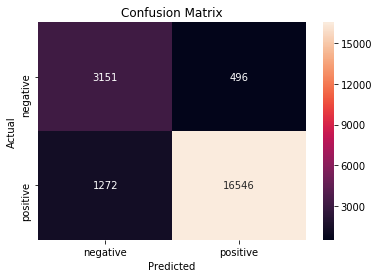

In [127]:
# Confusion matrix
print("Train confusion matrix")
matrix_train2= confusion_matrix(y_train, LR2.predict(X_train_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2 = pd.DataFrame(matrix_train2,columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test2= confusion_matrix(y_test, LR2.predict(X_test_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test2 = pd.DataFrame(matrix_test2,columns,index)
sns.heatmap(df_matrix_test2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [128]:
# Please write all the code with proper documentation

In [129]:
# Using Grid search method to find the optimal c.
logistic_ = LogisticRegression(penalty='l2', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf3 = GridSearchCV(logistic_, C, cv=3, scoring='roc_auc', return_train_score= True )
clf3= clf3.fit(X_train_tfidf_S, y_train)

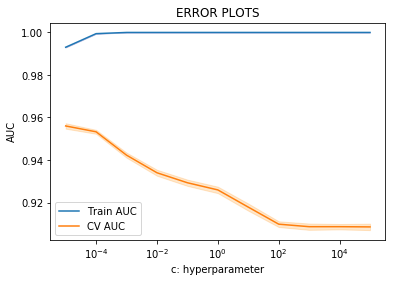

In [130]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc3= clf3.cv_results_['mean_train_score']
train_auc_std3= clf3.cv_results_['std_train_score']
cv_auc3 = clf3.cv_results_['mean_test_score'] 
cv_auc_std3= clf3.cv_results_['std_test_score']

plt.semilogx(c, train_auc3, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc3 - train_auc_std3,train_auc3 + train_auc_std3,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc3, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc3 - cv_auc_std3,cv_auc3 + cv_auc_std3,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [131]:
l=0
for i in c:
    print (i,train_auc3[l],cv_auc3[l],train_auc3[l]-cv_auc3[l] )
    l+=1

1e-05 0.9930442216290567 0.9560230338025051 0.037021187826551616
0.0001 0.9994359410031647 0.9532659542446273 0.04616998675853734
0.001 0.9999968312929056 0.9422843629184391 0.05771246837446653
0.01 0.9999982628757268 0.9340076725698402 0.06599059030588661
0.1 0.999998296361705 0.9293112055114146 0.07068709085029046
1 0.999998296361705 0.9259408566254723 0.07405743973623269
10 0.9999982963617048 0.9178489435120134 0.08214935284969138
100 0.999998296361705 0.9098302846784616 0.0901680116832434
1000 0.9999982963617048 0.9086474780404967 0.09135081832120806
10000 0.999998296361705 0.9086505156819193 0.09134778067978566
100000 0.999998296361705 0.9085513038834601 0.09144699247824495


In [132]:
print(clf3.best_estimator_)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [170]:
#best_c=0.0001

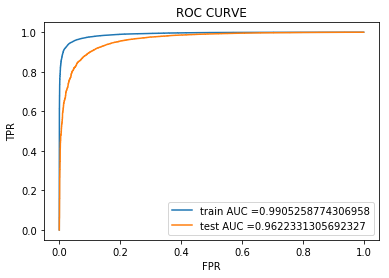

In [133]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR3 = LogisticRegression(penalty='l2', C=1e-05, class_weight = 'balanced')
LR3.fit(X_train_tfidf_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, LR3.predict_proba(X_train_tfidf_S)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, LR3.predict_proba(X_test_tfidf_S)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


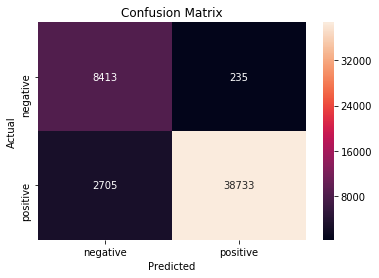

Test confusion matrix


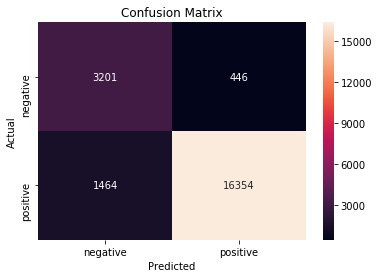

In [134]:
# Confusion Metric
print("Train confusion matrix")
matrix_train3= confusion_matrix(y_train, LR3.predict(X_train_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3 = pd.DataFrame(matrix_train3,columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test3= confusion_matrix(y_test, LR3.predict(X_test_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test3 = pd.DataFrame(matrix_test3,columns,index)
sns.heatmap(df_matrix_test3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.1.3.1] Top 10 important features of positive class using  L1 regularization on <font color='red'> SET 2</font>

In [135]:
# Please write all the code with proper documentation
feature_name1= tf_idf_vect.get_feature_names()
W1_l1=LR2.coef_ # Weight vector of tfidf using l1 regularization. 
positive_feat1 = np.argsort(W1_l1)[:,::-1] #Returns sorted indexs the features having the highest weights at the top
print("Top 10 positive features from tfidf:")
for i in list(positive_feat1[0][0:10]):
    print(feature_name1[i])

Top 10 positive features from tfidf:
great
best
love
good
delicious
perfect
loves
excellent
not disappointed
favorite


#### [5.2.3.2] Top 10 important features of negative class using L1 from<font color='red'> SET 2</font>

In [136]:
negative_feat1 = np.argsort(W1_l1)#Returns sorted indexs the features having the highest weights at the top
print("Top 10 negative features from tfidf:")
for i in list(negative_feat1[0][0:10]):
    print(feature_name1[i])

Top 10 negative features from tfidf:
disappointed
not
not recommend
worst
disappointing
terrible
not worth
bad
not good
awful


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [137]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard2 = StandardScaler(with_mean=False).fit(X_train_w2v) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_w2v_S = Standard2.transform(X_train_w2v)
X_test_w2v_S = Standard2.transform(X_test_w2v)

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [138]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Using Grid search method to find the optimal c.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf4 = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf4= clf4.fit(X_train_w2v_S, y_train)

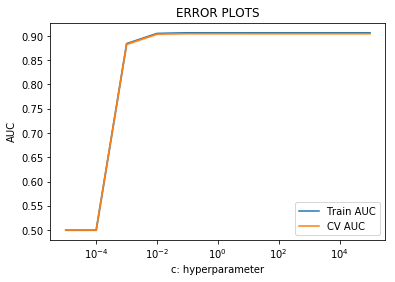

In [139]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum c.
train_auc4= clf4.cv_results_['mean_train_score']
train_auc_std4= clf4.cv_results_['std_train_score']
cv_auc4 = clf4.cv_results_['mean_test_score'] 
cv_auc_std4= clf4.cv_results_['std_test_score']

plt.semilogx(c, train_auc4, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc4 - train_auc_std4,train_auc4 + train_auc_std4,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc4, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc4 - cv_auc_std4,cv_auc4 + cv_auc_std4,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [140]:
l=0
for i in c:
    print (i,train_auc4[l],cv_auc4[l],train_auc4[l]-cv_auc4[l] )
    l+=1

1e-05 0.5 0.5 0.0
0.0001 0.5 0.5 0.0
0.001 0.8843080945878775 0.8831070982441731 0.001200996343704408
0.01 0.9053304573737142 0.9039748351164144 0.0013556222572997934
0.1 0.9066347174778958 0.9048926291703688 0.0017420883075269789
1 0.9066530883118661 0.9048440579277438 0.0018090303841222788
10 0.9066504973236693 0.904829166789379 0.001821330534290344
100 0.9066501415251702 0.9048287400751373 0.0018214014500329556
1000 0.9066496852301272 0.9048280201420416 0.0018216650880856777
10000 0.9066492854708068 0.9048280787697638 0.001821206701043021
100000 0.9066495784992208 0.9048282377860861 0.001821340713134667


In [141]:
print(clf4.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [181]:
#best_c=0.1 # lamda = 10

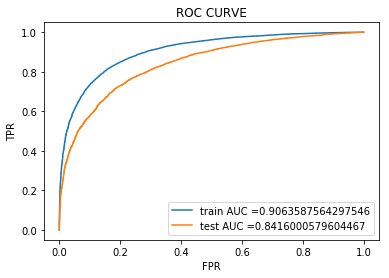

In [142]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR4 = LogisticRegression(penalty='l1', C=0.1, class_weight = 'balanced')
LR4.fit(X_train_w2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr4, train_tpr4, thresholds4 = roc_curve(y_train, LR4.predict_proba(X_train_w2v_S)[:,1])
test_fpr4, test_tpr4, thresholds4 = roc_curve(y_test, LR4.predict_proba(X_test_w2v_S)[:,1])

plt.plot(train_fpr4, train_tpr4, label="train AUC ="+str(auc(train_fpr4, train_tpr4)))
plt.plot(test_fpr4, test_tpr4, label="test AUC ="+str(auc(test_fpr4, test_tpr4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


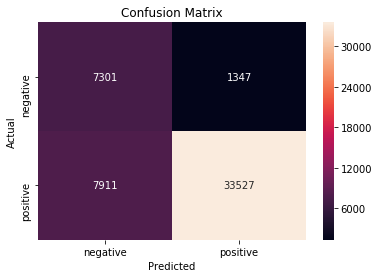

Test confusion matrix


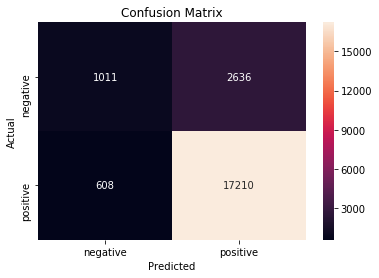

In [143]:
# Confusion matrix
print("Train confusion matrix")
matrix_train4= confusion_matrix(y_train, LR4.predict(X_train_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train4 = pd.DataFrame(matrix_train4,columns,index)
sns.heatmap(df_matrix_train4, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test4= confusion_matrix(y_test, LR4.predict(X_test_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test4= pd.DataFrame(matrix_test4,columns,index)
sns.heatmap(df_matrix_test4, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [144]:
logistic_ = LogisticRegression(penalty='l2', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf5 = GridSearchCV(logistic_, C, cv=3, scoring='roc_auc', return_train_score= True )
clf5= clf5.fit(X_train_w2v_S, y_train)

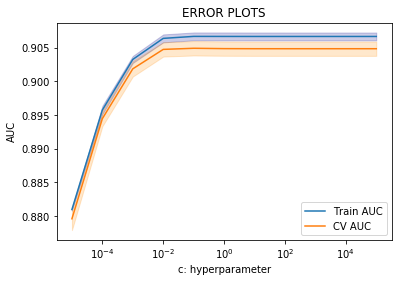

In [145]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc5= clf5.cv_results_['mean_train_score']
train_auc_std5= clf5.cv_results_['std_train_score']
cv_auc5 = clf5.cv_results_['mean_test_score'] 
cv_auc_std5= clf5.cv_results_['std_test_score']

plt.semilogx(c, train_auc5, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc5 - train_auc_std5,train_auc5 + train_auc_std5,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc5, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc5 - cv_auc_std5,cv_auc5 + cv_auc_std5,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [146]:
print(clf5.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [138]:
#best_c=0.1

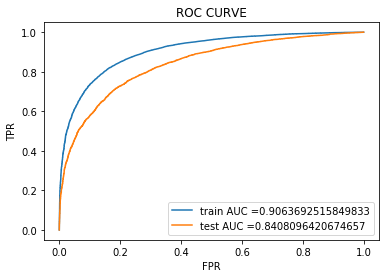

In [147]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
LR5 = LogisticRegression(penalty='l2', C=0.1, class_weight = 'balanced')
LR5.fit(X_train_w2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr5, train_tpr5, thresholds5 = roc_curve(y_train, LR5.predict_proba(X_train_w2v_S)[:,1])
test_fpr5, test_tpr5, thresholds5 = roc_curve(y_test, LR5.predict_proba(X_test_w2v_S)[:,1])

plt.plot(train_fpr5, train_tpr5, label="train AUC ="+str(auc(train_fpr5, train_tpr5)))
plt.plot(test_fpr5, test_tpr5, label="test AUC ="+str(auc(test_fpr5, test_tpr5)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


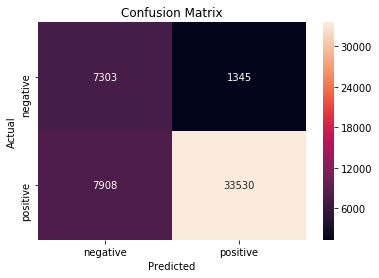

Test confusion matrix


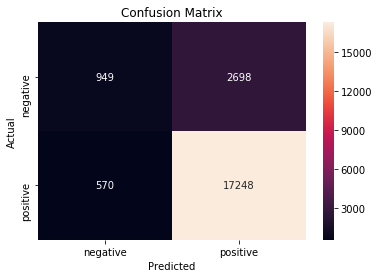

In [148]:
# Confusion matrix
print("Train confusion matrix")
matrix_train5= confusion_matrix(y_train, LR5.predict(X_train_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train5 = pd.DataFrame(matrix_train5,columns,index)
sns.heatmap(df_matrix_train5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test5= confusion_matrix(y_test, LR5.predict(X_test_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test5 = pd.DataFrame(matrix_test5,columns,index)
sns.heatmap(df_matrix_test5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [149]:
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard3= StandardScaler(with_mean=False).fit(X_train_tfidfw2v)
X_train_tfidfw2v_S = Standard3.transform(X_train_tfidfw2v)
X_test_tfidfw2v_S = Standard3.transform(X_test_tfidfw2v)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [150]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Using Grid search method to find the optimal c.
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf6 = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf6= clf6.fit(X_train_tfidfw2v_S, y_train)

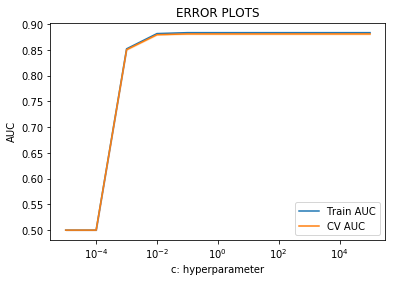

In [151]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc6= clf6.cv_results_['mean_train_score']
train_auc_std6= clf6.cv_results_['std_train_score']
cv_auc6 = clf6.cv_results_['mean_test_score'] 
cv_auc_std6= clf6.cv_results_['std_test_score']

plt.semilogx(c, train_auc6, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc6 - train_auc_std6,train_auc6 + train_auc_std6,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc6, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc6 - cv_auc_std6, cv_auc6 + cv_auc_std6, alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [152]:
print(clf6.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


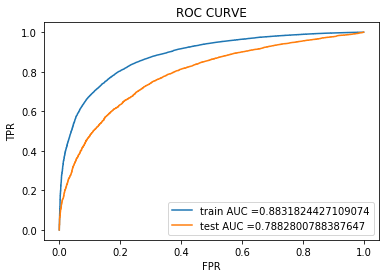

In [153]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR6 = LogisticRegression(penalty='l1', C=1, class_weight = 'balanced')
LR6.fit(X_train_tfidfw2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr6, train_tpr6, thresholds6 = roc_curve(y_train, LR6.predict_proba(X_train_tfidfw2v_S)[:,1])
test_fpr6, test_tpr6, thresholds6 = roc_curve(y_test, LR6.predict_proba(X_test_tfidfw2v_S)[:,1])

plt.plot(train_fpr6, train_tpr6, label="train AUC ="+str(auc(train_fpr6, train_tpr6)))
plt.plot(test_fpr6, test_tpr6, label="test AUC ="+str(auc(test_fpr6, test_tpr6)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


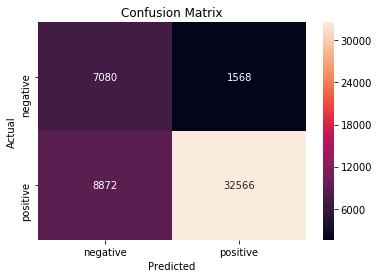

Test confusion matrix


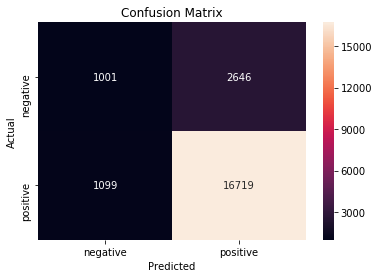

In [154]:
# Confusion matrix
print("Train confusion matrix")
matrix_train6= confusion_matrix(y_train, LR6.predict(X_train_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train6 = pd.DataFrame(matrix_train6,columns,index)
sns.heatmap(df_matrix_train6, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test6= confusion_matrix(y_test, LR6.predict(X_test_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test6 = pd.DataFrame(matrix_test6,columns,index)
sns.heatmap(df_matrix_test6, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [155]:
# Using Grid search method to find the optimal c.
logistic_ = LogisticRegression(penalty='l2', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf7 = GridSearchCV(logistic_, C, cv=3, scoring='roc_auc', return_train_score= True )
clf7= clf7.fit(X_train_tfidfw2v_S, y_train)

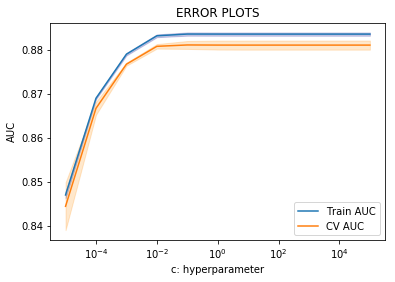

In [156]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum C
train_auc7= clf7.cv_results_['mean_train_score']
train_auc_std7= clf7.cv_results_['std_train_score']
cv_auc7 = clf7.cv_results_['mean_test_score'] 
cv_auc_std7= clf7.cv_results_['std_test_score']

plt.semilogx(c, train_auc7, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc7 - train_auc_std7,train_auc7 + train_auc_std7,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc7, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc7 - cv_auc_std7,cv_auc7 + cv_auc_std7,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [157]:
print(clf7.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


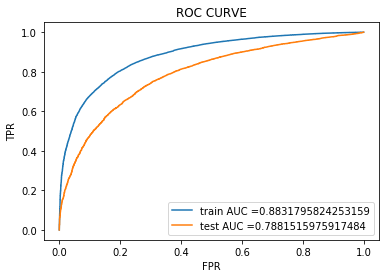

In [158]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR7 = LogisticRegression(penalty='l2', C=1, class_weight = 'balanced')
LR7.fit(X_train_tfidfw2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr7, train_tpr7, thresholds7 = roc_curve(y_train, LR7.predict_proba(X_train_tfidfw2v_S)[:,1])
test_fpr7, test_tpr7, thresholds7 = roc_curve(y_test, LR7.predict_proba(X_test_tfidfw2v_S)[:,1])

plt.plot(train_fpr7, train_tpr7, label="train AUC ="+str(auc(train_fpr7, train_tpr7)))
plt.plot(test_fpr7, test_tpr7, label="test AUC ="+str(auc(test_fpr7, test_tpr7)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


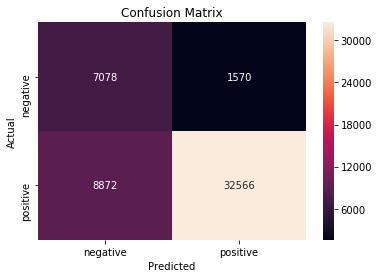

Test confusion matrix


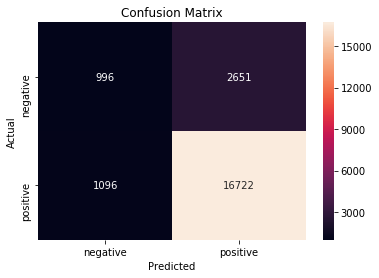

In [159]:
# Confusion Metric
print("Train confusion matrix")
matrix_train7= confusion_matrix(y_train, LR7.predict(X_train_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train7 = pd.DataFrame(matrix_train7,columns,index)
sns.heatmap(df_matrix_train7, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test7= confusion_matrix(y_test, LR7.predict(X_test_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test7 = pd.DataFrame(matrix_test7,columns,index)
sns.heatmap(df_matrix_test7, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## [6]. Feature engineering:

In [160]:
# Finding the lenght of the review:
Review_len = [len(sentence.split()) for sentence in preprocessed_reviews]

In [161]:
Review_len[1500]

20

In [162]:
preprocessed_reviews[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue'

In [163]:
#Adding review length and summary to preprocessed_review as the part of Feature engineering:
preprocessed_reviews1= []
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]+' '+str(Review_len[i])
    preprocessed_reviews1.append(preprocessed_reviews[i])

In [164]:
preprocessed_reviews1[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue bad product 20'

In [165]:
X1= preprocessed_reviews1
Y1 = Score

In [166]:
np.shape(X1)

(71551,)

In [167]:
np.shape(Y1)

(71551,)

In [168]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X1_train= X[0:50086]
X1_test= X[50086:]
y1_train= Y[0:50086]
y1_test= Y[50086:]

### [6.1] FE: Applying Logistic Regression with L1 regularization on Bow, <font color='red'> SET 5</font>

In [169]:
#BoW
count_vect1 = CountVectorizer()
count_vect1.fit(X1_train) # fit has to happen only on train data

X_train_fe_bow = count_vect1.transform(X1_train)
X_test_fe_bow = count_vect1.transform(X1_test)

print("the type of count vectorizer ",type(X_train_fe_bow))
print("the number of unique words in X_train_fe",X_train_fe_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_fe_bow.shape, y1_train.shape)
print(X_test_fe_bow.shape, y1_test.shape)
print("="*50)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train_fe 44869
After vectorizations
(50086, 44869) (50086,)
(21465, 44869) (21465,)


In [170]:
# Standardizing both X_TRAIN_fe_BOW AND X_TEST_fe_BOW
Standard4= StandardScaler(with_mean=False).fit(X_train_fe_bow)
X_train_fe_bow_S = Standard4.transform(X_train_fe_bow)
X_test_fe_bow_S = Standard4.transform(X_test_fe_bow)

In [171]:
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf8 = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf8= clf8.fit(X_train_fe_bow_S, y1_train)

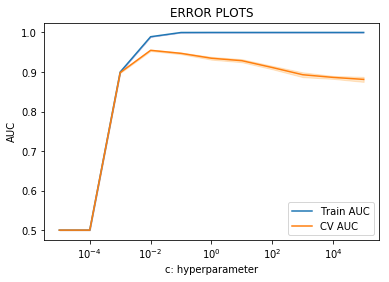

In [172]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum c.
train_auc8= clf8.cv_results_['mean_train_score']
train_auc_std8= clf8.cv_results_['std_train_score']
cv_auc8 = clf8.cv_results_['mean_test_score'] 
cv_auc_std8= clf8.cv_results_['std_test_score']

plt.semilogx(c, train_auc8, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc8 - train_auc_std8,train_auc8 + train_auc_std8,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc8, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc8 - cv_auc_std8,cv_auc8 + cv_auc_std8,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [173]:
print(clf8.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


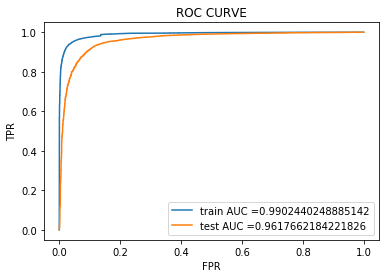

In [174]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR8 = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
LR8.fit(X_train_fe_bow_S, y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr8, train_tpr8, thresholds8 = roc_curve(y1_train, LR8.predict_proba(X_train_fe_bow_S)[:,1])
test_fpr8, test_tpr8, thresholds8 = roc_curve(y1_test, LR8.predict_proba(X_test_fe_bow_S)[:,1])

plt.plot(train_fpr8, train_tpr8, label="train AUC ="+str(auc(train_fpr8, train_tpr8)))
plt.plot(test_fpr8, test_tpr8, label="test AUC ="+str(auc(test_fpr8, test_tpr8)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


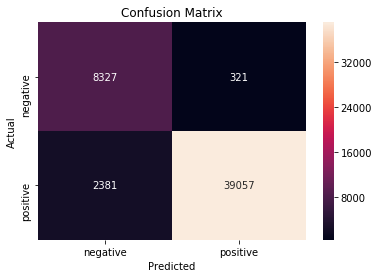

Test confusion matrix


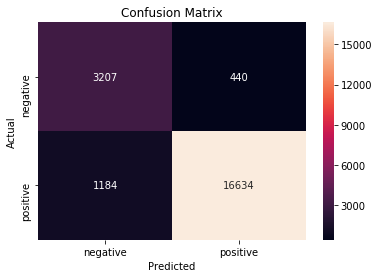

In [175]:
# Confusion matrix
print("Train confusion matrix")
matrix_train8= confusion_matrix(y1_train, LR8.predict(X_train_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train8 = pd.DataFrame(matrix_train8,columns,index)
sns.heatmap(df_matrix_train8, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test8= confusion_matrix(y1_test, LR8.predict(X_test_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test8 = pd.DataFrame(matrix_test8,columns,index)
sns.heatmap(df_matrix_test8, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [6.2] FE: Applying Logistic Regression with L1 regularization on TFIDF, <font color='red'> SET 6</font>

In [176]:
#tfidf
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect1.fit(X1_train)
print('='*50)

X_train_fe_tfidf = tf_idf_vect1.transform(X1_train)
X_test_fe_tfidf = tf_idf_vect1.transform(X1_test)
print("the type of tf_idf_vect1",type(X_train_fe_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_fe_tfidf.shape, y1_train.shape)
print(X_test_fe_tfidf.shape, y1_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect1 of X_train_fe ", X_train_fe_tfidf.shape[1])

the type of tf_idf_vect1 <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 32685) (50086,)
(21465, 32685) (21465,)
The number of unique words in tf_idf_vect1 of X_train_fe  32685


In [177]:
# Standardizing both X_TRAIN_BOW AND X_TEST_BOW
Standard5= StandardScaler(with_mean=False).fit(X_train_fe_tfidf)
X_train_fe_tfidf_S = Standard5.transform(X_train_fe_tfidf)
X_test_fe_tfidf_S = Standard5.transform(X_test_fe_tfidf)

In [178]:
logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
c= [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here c is the hyperparameter and it is the inverse of lamda.
C= [{'C':c}]
clf9 = GridSearchCV(logistic, C, cv=3, scoring='roc_auc', return_train_score= True )
clf9= clf9.fit(X_train_fe_tfidf_S, y1_train)

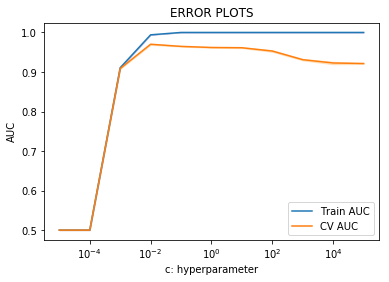

In [179]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc9= clf9.cv_results_['mean_train_score']
train_auc_std9= clf9.cv_results_['std_train_score']
cv_auc9 = clf9.cv_results_['mean_test_score'] 
cv_auc_std9= clf9.cv_results_['std_test_score']

plt.semilogx(c, train_auc9, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,train_auc9 - train_auc_std9,train_auc9 + train_auc_std9,alpha=0.2,color='darkblue')

plt.semilogx(c, cv_auc9, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(c,cv_auc9 - cv_auc_std9,cv_auc9 + cv_auc_std9,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [180]:
print(clf9.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


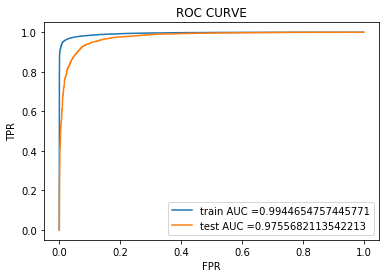

In [181]:
#training our model with the best optimal c, and find the AUC on test data and plot the ROC curve on both train and test. 
LR9 = LogisticRegression(penalty='l1', C=0.01, class_weight = 'balanced')
LR9.fit(X_train_fe_tfidf_S, y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr9, train_tpr9, thresholds9 = roc_curve(y1_train, LR9.predict_proba(X_train_fe_tfidf_S)[:,1])
test_fpr9, test_tpr9, thresholds9 = roc_curve(y1_test, LR9.predict_proba(X_test_fe_tfidf_S)[:,1])

plt.plot(train_fpr9, train_tpr9, label="train AUC ="+str(auc(train_fpr9, train_tpr9)))
plt.plot(test_fpr9, test_tpr9, label="test AUC ="+str(auc(test_fpr9, test_tpr9)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


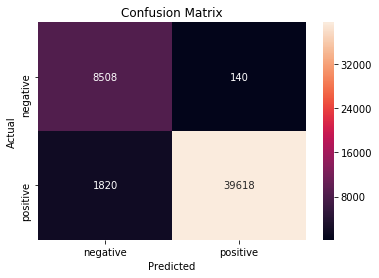

Test confusion matrix


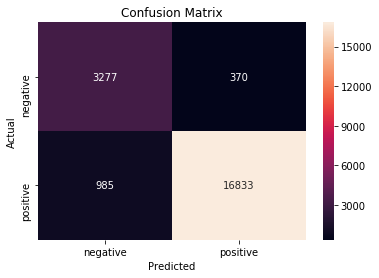

In [182]:
# Confusion matrix
print("Train confusion matrix")
matrix_train9= confusion_matrix(y1_train, LR9.predict(X_train_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train9 = pd.DataFrame(matrix_train9,columns,index)
sns.heatmap(df_matrix_train9, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test9= confusion_matrix(y1_test, LR9.predict(X_test_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test9 = pd.DataFrame(matrix_test9,columns,index)
sns.heatmap(df_matrix_test9, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [183]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Regularization", "FE Data","Hyperparameter-Alpha", "Test AUC"]
x.add_row(["Logistic Regression","BOW", "L1","No", 0.01, 0.9447])
x.add_row(["Logistic Regression","BOW", "L2", "No", 1e-05, 0.9328])
x.add_row(["Logistic Regression","TFIDF","L1", "No", 0.01, 0.9628])
x.add_row(["Logistic Regression","TFIDF", "L2","No", 1e-05, 0.9622])
x.add_row(["Logistic Regression","Avg W2V","L1","No", 0.1, 0.8416])
x.add_row(["Logistic Regression","Avg W2V","L2", "No", 0.1, 0.8406])
x.add_row(["Logistic Regression","TFIDF Avg W2v ","L1", "No", 1, 0.7882])
x.add_row(["Logistic Regression","TFIDF Avg W2v","L2", "No", 0.1, 0.7881])
x.add_row(["Logistic Regression","BOW", "L1","Yes", 0.01, 0.9617])
x.add_row(["Logistic Regression","TFIDF", "L1","Yes", 0.01, 0.9755])
print ("Summarize the results: ")
print(x)

Summarize the results: 
+---------------------+----------------+----------------+---------+----------------------+----------+
|        Model        |   Vectorizer   | Regularization | FE Data | Hyperparameter-Alpha | Test AUC |
+---------------------+----------------+----------------+---------+----------------------+----------+
| Logistic Regression |      BOW       |       L1       |    No   |         0.01         |  0.9447  |
| Logistic Regression |      BOW       |       L2       |    No   |        1e-05         |  0.9328  |
| Logistic Regression |     TFIDF      |       L1       |    No   |         0.01         |  0.9628  |
| Logistic Regression |     TFIDF      |       L2       |    No   |        1e-05         |  0.9622  |
| Logistic Regression |    Avg W2V     |       L1       |    No   |         0.1          |  0.8416  |
| Logistic Regression |    Avg W2V     |       L2       |    No   |         0.1          |  0.8406  |
| Logistic Regression | TFIDF Avg W2v  |       L1       | 

# Conclusions

- Highest test Auc of 0.9755 found using vectorizer TFIDF with C value of 0.01 using L1 vectorizer on FE data.
- All the model always perform good on training data than the test data.
- On applying FE on the last 2 sets we noted that the Test AUC have increased. Hence we can conclude that the performance of medel has improved.

#### Reference:
- www.appliedaicourse.com
- https://stackoverflow.com
